In [ ]:
pip install pandas numpy xgboost scikit-learn matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


開始訓練模型...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:33:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- 模型評估報告 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



<Figure size 1000x600 with 0 Axes>

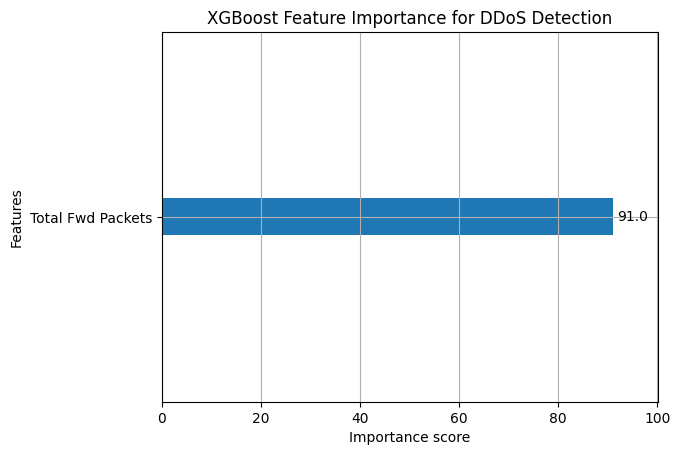

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 載入數據 (這裡假設你已經將數據處理成 parquet)
# 假設標籤欄位為 'Label' (0: Normal, 1: DDoS)
# df = pd.read_parquet('/content/drive/MyDrive/path/to/your/archive/DNS-testing.parquet') # Updated to read parquet

# --- 模擬數據生成 (為了讓程式碼可執行) ---
np.random.seed(42)
n_samples = 10000
data = {
    'Flow Duration': np.random.exponential(scale=100, size=n_samples),
    'Total Fwd Packets': np.random.poisson(lam=20, size=n_samples),
    'Total Bwd Packets': np.random.poisson(lam=15, size=n_samples),
    'Packet Length Std': np.random.normal(loc=50, scale=10, size=n_samples),
    'SYN Flag Count': np.random.randint(0, 2, size=n_samples),
    'ACK Flag Count': np.random.randint(0, 2, size=n_samples),
}
df = pd.DataFrame(data)
# 簡單製造一些"攻擊"特徵的差異
df['Label'] = 0
attack_indices = np.random.choice(df.index, size=2000, replace=False)
df.loc[attack_indices, 'Total Fwd Packets'] += 100  # 攻擊時封包數暴增
df.loc[attack_indices, 'SYN Flag Count'] = 1        # 攻擊時 SYN 較多
df.loc[attack_indices, 'Label'] = 1                 # 設定為攻擊
# ----------------------------------------

# 2. 數據切分
X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 建立 XGBoost 模型
# scale_pos_weight 非常重要，因為 DDoS 數據通常是不平衡的 (正常流量 >> 攻擊流量)
# 設定為 (負樣本數 / 正樣本數)
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio,  # 處理數據不平衡
    use_label_encoder=False,
    eval_metric='logloss'
)

# 4. 訓練
print("開始訓練模型...")
model.fit(X_train, y_train)

# 5. 預測與評估
y_pred = model.predict(X_test)

print("\n--- 模型評估報告 ---")
print(classification_report(y_test, y_pred))

# 6. 特徵重要性分析 (Feature Importance)
# 這能告訴你哪種網路特徵最能識別 DDoS
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('XGBoost Feature Importance for DDoS Detection')
plt.show()

**AI studio生成的範本**
基於您提供的研究計畫書架構，將核心的深度學習模型替換為 XGBoost，但保留了計畫書中提到的「資料前處理」、「二元分類（異常偵測）」以及「關鍵評估指標（F1-Score, AUROC, Latency, FPR）」的流程。
此程式碼可直接在 Google Colab 上執行。為了能立即跑出結果，使用了**NSL-KDD** 公開資料集（自動下載）。

步驟 1: 環境建置完成
步驟 2: 下載並讀取 NSL-KDD 資料集...
訓練集大小: (125973, 42)
測試集大小: (22544, 42)
步驟 3: 資料前處理完成 (二元分類轉換、類別編碼)
步驟 4: 開始訓練 XGBoost 模型...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:11:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


模型訓練完成，耗時: 12.3096 秒
步驟 5: 進行模型效能評估...
Latency: 0.0146 ms

===== Evaluation Results =====
Accuracy: 0.8097
F1-Score: 0.8045 (計畫書重點指標)
AUROC: 0.9679 (計畫書重點指標)
FPR: 0.0292 (計畫書重點指標)


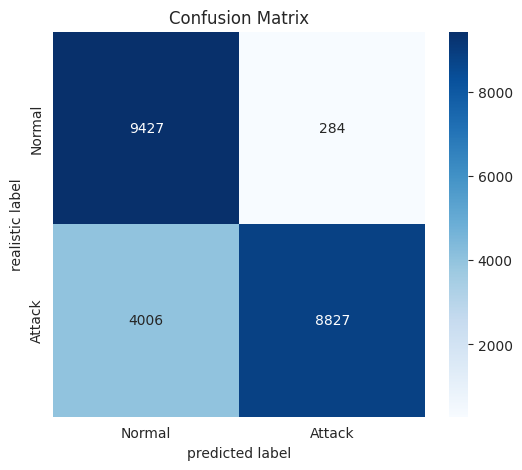

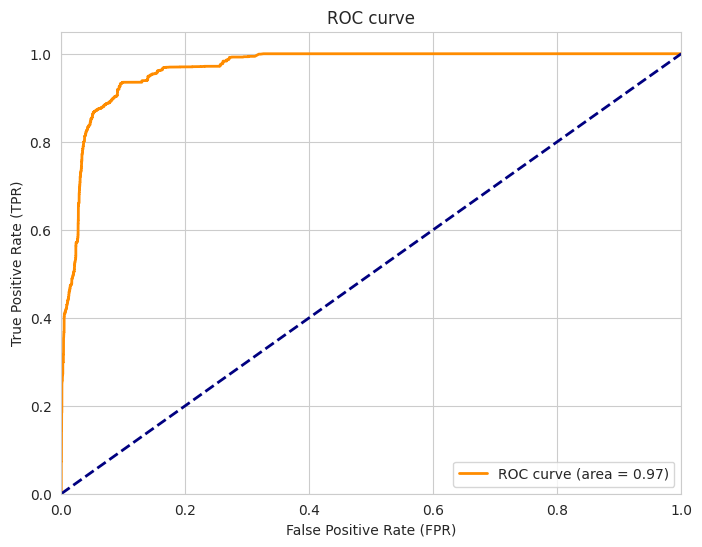

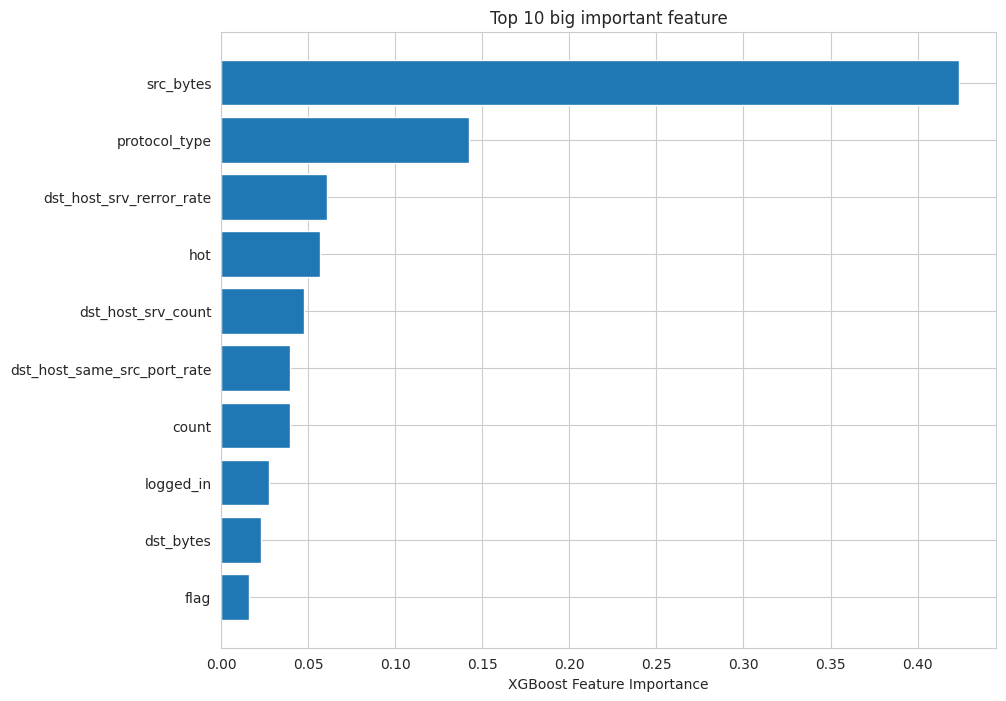

In [ ]:
# ==========================================
# 基於研究計畫書之網路異常流量偵測模型 (XGBoost版)
# 適用環境: Google Colab
# ==========================================

# 1. 環境建置與套件匯入
import pandas as pd
import numpy as np
import time
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score)
from xgboost import XGBClassifier

# 設定繪圖風格
sns.set_style("whitegrid")

print("步驟 1: 環境建置完成")

# 2. 資料獲取與載入 (對應計畫書 3.2 資料來源)
# 使用 NSL-KDD 資料集 (學術界常用的 IDS 資料集)
# 定義資料集欄位名稱 (NSL-KDD 共有 41 個特徵 + 1 個標籤)
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# 下載訓練集與測試集 (從 GitHub 來源)
print("步驟 2: 下載並讀取 NSL-KDD 資料集...")
url_train = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
url_test = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"

df_train = pd.read_csv(url_train, header=None, names=columns)
df_test = pd.read_csv(url_test, header=None, names=columns)

# 移除最後一欄 'difficulty' (不需要用於訓練)
df_train = df_train.drop('difficulty', axis=1)
df_test = df_test.drop('difficulty', axis=1)

print(f"訓練集大小: {df_train.shape}")
print(f"測試集大小: {df_test.shape}")

# 3. 資料前處理與特徵工程 (對應計畫書 3.2 資料前處理)

# 3.1 標籤編碼 (Label Encoding) - 將攻擊類型轉為二元分類 (正常=0, 異常=1)
# 原始資料標籤為具體攻擊名稱 (如 neptune, smurf)，我們將 'normal' 視為 0，其餘視為 1
def convert_label(label):
    if label == 'normal':
        return 0
    else:
        return 1

df_train['target'] = df_train['label'].apply(convert_label)
df_test['target'] = df_test['label'].apply(convert_label)

# 移除原始 label 欄位
df_train = df_train.drop('label', axis=1)
df_test = df_test.drop('label', axis=1)

# 3.2 類別特徵處理
# 將 protocol_type, service, flag 等字串欄位轉為數值
categorical_cols = ['protocol_type', 'service', 'flag']
le = LabelEncoder()

# 為了確保訓練集和測試集的編碼一致，將兩者合併處理後再分開
combined_df = pd.concat([df_train, df_test])

for col in categorical_cols:
    combined_df[col] = le.fit_transform(combined_df[col])

# 分回訓練集與測試集
df_train = combined_df.iloc[:len(df_train)]
df_test = combined_df.iloc[len(df_train):]

# 準備 X (特徵) 與 y (標籤)
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

print("步驟 3: 資料前處理完成 (二元分類轉換、類別編碼)")

# 4. 模型建構與訓練 (對應計畫書 3.3，但改用 XGBoost)
print("步驟 4: 開始訓練 XGBoost 模型...")

# 初始化 XGBoost 分類器
# 這裡使用較通用的參數，實務上可如計畫書所述使用貝葉斯優化調整
model = XGBClassifier(
    n_estimators=100,       # 樹的數量
    learning_rate=0.1,      # 學習率
    max_depth=6,            # 樹的深度
    use_label_encoder=False,
    eval_metric='logloss',  # 評估指標
    random_state=42
)

# 紀錄訓練時間
start_train = time.time()
model.fit(X_train, y_train)
end_train = time.time()

print(f"模型訓練完成，耗時: {end_train - start_train:.4f} 秒")

# 5. 效能評估 (對應計畫書 3.5 效能評估指標)
print("步驟 5: 進行模型效能評估...")

# 5.1 推論延遲 (Latency) 測試
start_infer = time.time()
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # 取得預測為異常的機率
end_infer = time.time()

latency = (end_infer - start_infer) / len(X_test)
print(f"Latency: {latency * 1000:.4f} ms")

# 5.2 計算各項指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 計算混淆矩陣以取得 FPR (誤報率)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn) # False Positive Rate

print("\n===== Evaluation Results =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f} (計畫書重點指標)")
print(f"AUROC: {roc_auc:.4f} (計畫書重點指標)")
print(f"FPR: {fpr:.4f} (計畫書重點指標)")

# 5.3 繪製混淆矩陣
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('realistic label')
plt.xlabel('predicted label')
plt.show()

# 5.4 繪製 ROC 曲線
fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# 5.5 特徵重要性 (額外展示：XGBoost 的優勢)
plt.figure(figsize=(10, 8))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.title("Top 10 big important feature")
plt.show()